# Siamese Neural Networks
Recognize images of icebergs from images of ships. 
These images were taken from space with a Sentinel-4 satellite. The goal was to create the most accurate neural network to differentiate them. However, neural networks usually only work well with A LOT of data, and I constrained you guys to 1000 examples to train on. That seems like a lot, but a CONVENTIONAL neural network needs more data. However, we are going to make a special kind of neural network: *Siamese Network*. This special network is used for face recognition and few-shot learning(learning from few examples). Let's get started by importing the usual liraries:

In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

Using TensorFlow backend.


## Load the Data


In [2]:
npz = np.load('input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']
del npz
print ('We have {} examples to work with'.format(Y_train.shape[0]-1000))

We have 3113 examples to work with


## Check the data

Load some of the images to observe how your data look like.

In [3]:
import matplotlib.image as mpimg
import cv2
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


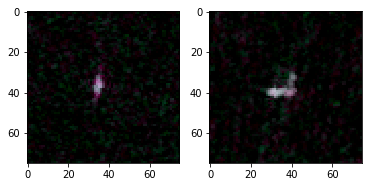

In [4]:
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(X_train[0])
f.add_subplot(1,2, 2)
plt.imshow(X_train[1])
plt.show(block=True)

# Creating the structure of Siamese Network

# Create two Inputs for each image - left_input and right_input
Hint - use Input Function in Keras and keep the shape to be 75,75,3

In [5]:
left_input = Input((75,75,3))
right_input = Input((75,75,3))

# Create a base Network in which both images will go through individually.

Hint - Use Sequential Model in Keras with convolution layers, Maxpooling Layers, Flatten Layer and Denser Layer with appropriate activation functions.
Name the network as base_network

In [7]:
base_network = Sequential()
base_network.add(Conv2D(5,3,input_shape=(75,75,3), activation='relu'))
base_network.add(MaxPooling2D())
base_network.add(Conv2D(5,3,activation='relu'))
base_network.add(MaxPooling2D())
base_network.add(Conv2D(7,2,activation='relu'))
base_network.add(MaxPooling2D())
base_network.add(Conv2D(7,2,activation='relu'))
base_network.add(Flatten())
base_network.add(Dense(18, activation='sigmoid'))

# Process the left and right inputs to the same Base Network(base_network)

In [8]:
processed_left = base_network(left_input)
processed_right = base_network(right_input)

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)
Hint - You can use Lambda function for this.

In [9]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [10]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_left, processed_right])

# Add the prediction layer in the end and create the Siamese Network using Model function.

In [12]:
model = Model(input=[left_input, right_input], output=distance)

C:\AIML\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


# Define the Optimizer Adam and Compile the Siamese Model.

In [13]:
adam = Adam(0.001, decay=2.5e-4)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Show the Summary of your Siamese Network

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 18)           6912        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_2[1][0]               
          

# Creating the Pair of Images to train on

It's not time to train though. We still have to create pairs of images to train on. There will be Positive(the same class) or Negative(different classes) for outputs. Let's construct this dataset. It is recommended that there are equal amounts positive and negative.

In [15]:
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

pairs = 5
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: 
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:
            targets.append(1.)
        else:
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

Now we have a lot more examples.
Now we have pairs x 1000 examples to train the network on. 
Each side will have an input of an image and the output will be one if they are the same and zero if not.

# Train the Siamese train on left and right input image pairs created and validate it by test pairs.

In [17]:
model.fit([left_input,right_input], targets,
          batch_size=16,
          epochs=30,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))

Train on 5000 samples, validate on 3113 samples
Epoch 1/30
5000/5000 [==============================] - 43s 9ms/step - loss: 0.8402 - acc: 0.5032 - val_loss: 0.7534 - val_acc: 0.4266
Epoch 2/30
5000/5000 [==============================] - 45s 9ms/step - loss: 0.7243 - acc: 0.5092 - val_loss: 0.8318 - val_acc: 0.4684
Epoch 3/30
5000/5000 [==============================] - 45s 9ms/step - loss: 0.7011 - acc: 0.5312 - val_loss: 0.7681 - val_acc: 0.4677
Epoch 4/30
5000/5000 [==============================] - 45s 9ms/step - loss: 0.6839 - acc: 0.5524 - val_loss: 0.7995 - val_acc: 0.4600
Epoch 5/30
5000/5000 [==============================] - 45s 9ms/step - loss: 0.6699 - acc: 0.5838 - val_loss: 0.7488 - val_acc: 0.4404
Epoch 6/30
5000/5000 [==============================] - 45s 9ms/step - loss: 0.6553 - acc: 0.6116 - val_loss: 0.7388 - val_acc: 0.4449
Epoch 7/30
5000/5000 [==============================] - 45s 9ms/step - loss: 0.6466 - acc: 0.6234 - val_loss: 0.7423 - val_acc: 0.4600
Epoch 8